In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.graph_objects as go
import plotly.express as px

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams.update({'font.size': 16})

In [2]:
np.random.seed(7)

In [3]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 15)

In [4]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [5]:
df = pd.read_csv(url)
df['date'] = pd.to_datetime(df['date'])
df['location'] = df['location'].replace(['United States'],'United_States')
df['location'] = df['location'].replace(['United Kingdom'],'United_Kingdom')

### Start date to analysis: 2020-03-01

In [6]:
df = df.loc[:,['date', 'location', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
df = df[(df['date'] > '2020-03-01')]
df = df.sort_values(by=['total_cases'], ascending=True)

### Brazil Cases

In [7]:
dfBrazil = df[df['location'] == 'Brazil']
dfBrazil = dfBrazil.sort_values(by='date', ascending=True)
dfBrazil.reset_index(drop=True, inplace=True)
dfBrazil

,date,location,total_cases,total_deaths,new_cases,new_deaths
0,2020-03-02,Brazil,2.0,0.0,0.0,0.0
1,2020-03-03,Brazil,2.0,0.0,0.0,0.0
2,2020-03-04,Brazil,2.0,0.0,0.0,0.0
3,2020-03-05,Brazil,3.0,0.0,1.0,0.0
4,2020-03-06,Brazil,8.0,0.0,5.0,0.0
...,...,...,...,...,...,...
139,2020-07-19,Brazil,2074860.0,78772.0,28532.0,921.0
140,2020-07-20,Brazil,2098389.0,79488.0,23529.0,716.0
141,2020-07-21,Brazil,2118646.0,80120.0,20257.0,632.0
142,2020-07-22,Brazil,2159654.0,81487.0,41008.0,1367.0


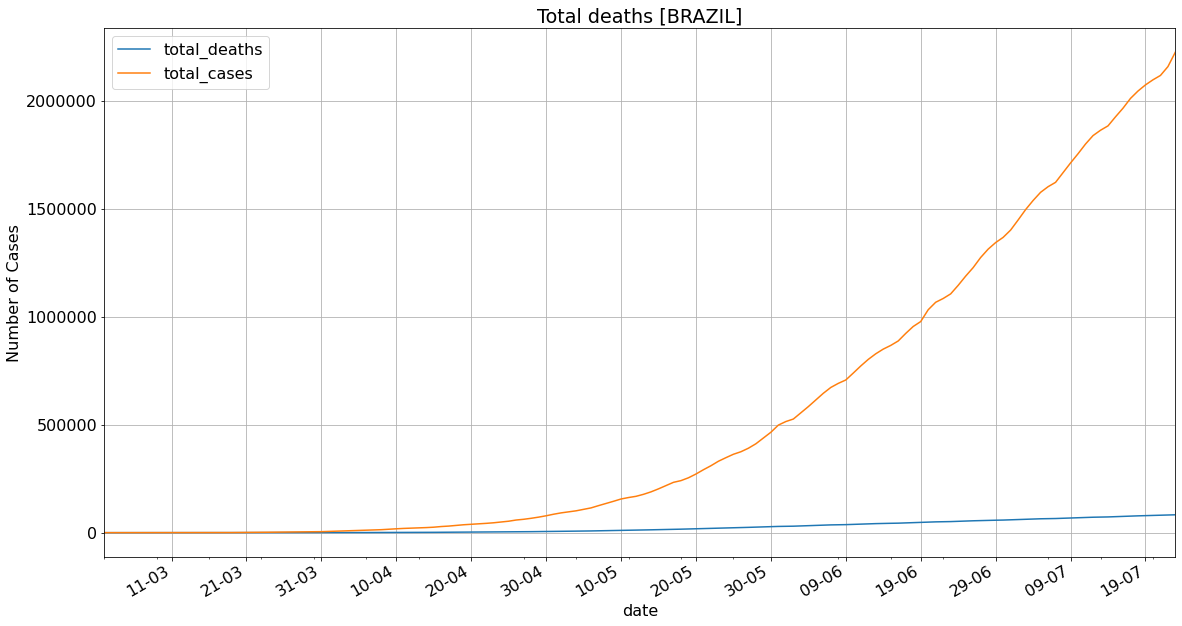

In [8]:
dfBrazil.plot(x='date', y=['total_deaths','total_cases'], figsize=(19.20,10.80))

plt.ylabel('Number of Cases')
plt.title('Total deaths [BRAZIL]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### New deaths [Brazil]

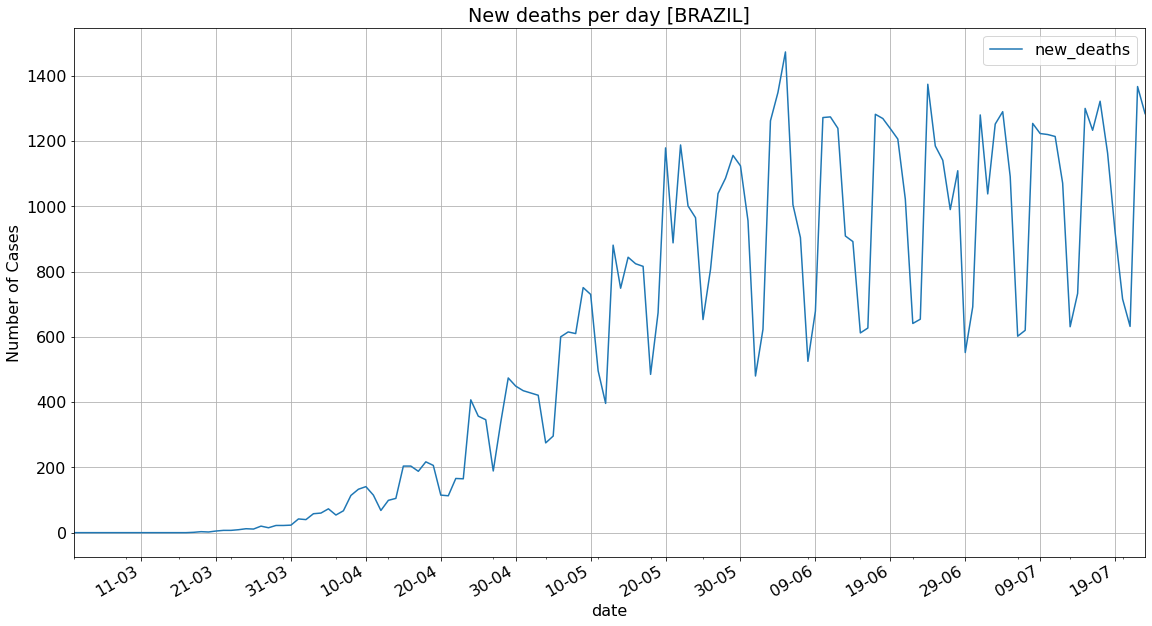

In [9]:
dfBrazil.plot(x='date', y='new_deaths', figsize=(19.20,10.80))

plt.ylabel('Number of Cases')
plt.title('New deaths per day [BRAZIL]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### LSTM Network for Regression

In [10]:
dfPredict = dfBrazil.loc[:,['date','new_deaths']]
dfPredict = dfPredict[(dfBrazil['new_deaths'] > 200)]
dfPredict = dfPredict.sort_values(by='date', ascending=True)
dfPredict['date'] = dfPredict['date'].dt.year.astype('str')+'-'+dfPredict['date'].dt.month.astype('str')+'-'+dfPredict['date'].dt.day.astype('str')
dfPredict.reset_index(drop=True, inplace=True)
dfPredict

,date,new_deaths
0,2020-4-15,204.0
1,2020-4-16,204.0
2,2020-4-18,217.0
3,2020-4-19,206.0
4,2020-4-24,407.0
...,...,...
89,2020-7-19,921.0
90,2020-7-20,716.0
91,2020-7-21,632.0
92,2020-7-22,1367.0


In [11]:
dfDeaths = dfPredict.drop(['date'],axis=1)

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dfDeaths)

In [13]:
train_size = int(len(dataset)*0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

70 24


In [14]:
def create_dataset(dataset, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookBack-1):
        a = dataset[i:(i+lookBack),0]
        dataX.append(a)
        dataY.append(dataset[i+lookBack,0])
    return np.array(dataX), np.array(dataY)

In [15]:
lookBack = 1
trainX, trainY = create_dataset(train, lookBack)
testX, testY = create_dataset(test, lookBack)

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
model = keras.Sequential()
model.add(keras.layers.LSTM(512, input_shape=(1, lookBack)))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
68/68 [==============================] - 1s 19ms/step - loss: 0.1053 - mse: 0.1053
Epoch 2/50
68/68 [==============================] - 1s 19ms/step - loss: 0.0414 - mse: 0.0414
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 0.0394 - mse: 0.0394
Epoch 4/50
68/68 [==============================] - 1s 17ms/step - loss: 0.0367 - mse: 0.0367
Epoch 5/50
68/68 [==============================] - 1s 17ms/step - loss: 0.0349 - mse: 0.0349
Epoch 6/50
68/68 [==============================] - 1s 19ms/step - loss: 0.0338 - mse: 0.0338
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 0.0341 - mse: 0.0341
Epoch 8/50
68/68 [==============================] - 1s 13ms/step - loss: 0.0346 - mse: 0.0346
Epoch 9/50
68/68 [==============================] - 1s 17ms/step - loss: 0.0363 - mse: 0.0363
Epoch 10/50
68/68 [==============================] - 1s 13ms/step - loss: 0.0344 - mse: 0.0344
Epoch 11/50
68/68 [==============================] - 1s 14m

In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [19]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [20]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 228.71 RMSE
Test Score: 300.08 RMSE


In [21]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict

In [22]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(dataset)-1, :] = testPredict

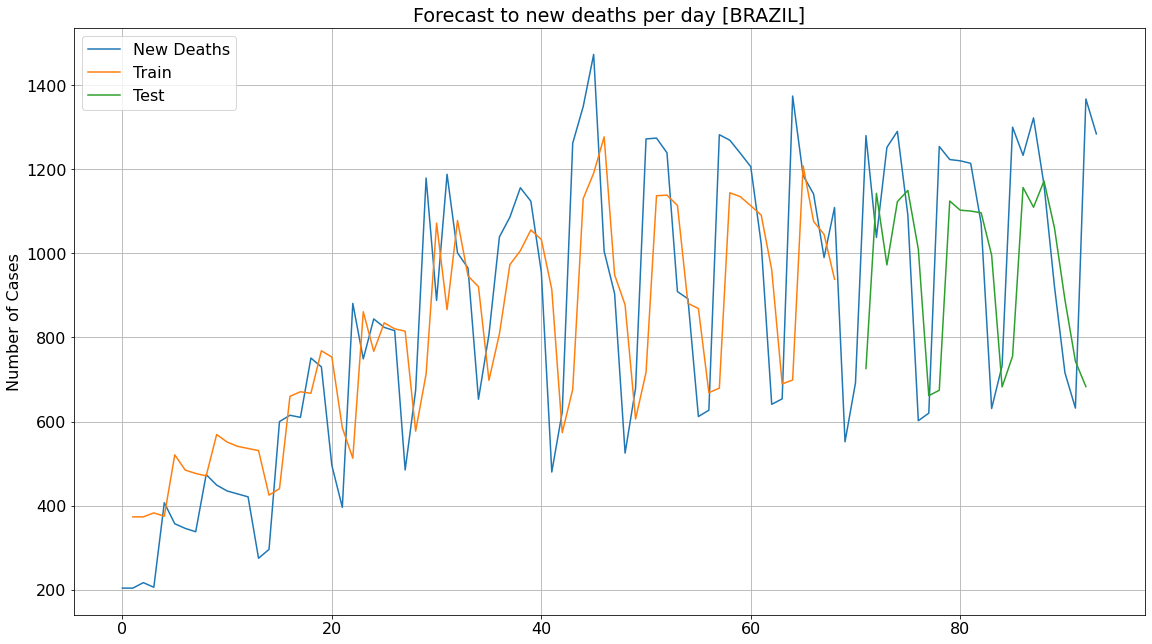

In [23]:
fig = plt.gcf()
fig.set_size_inches(19.20,10.80)

plt.ylabel('Number of Cases')
plt.title('Forecast to new deaths per day [BRAZIL]')

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.gca().legend(('New Deaths','Train','Test'))

plt.grid()
plt.show()